## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [2]:
import math
import os
import numpy as np
from numba import cuda, vectorize, float32, float64, jit
import matplotlib.pyplot as plt
#os.environ["NUMBA_ENABLE_CUDASIM"] = "1"

In [2]:
@vectorize([float32(float32)], target='parallel', fastmath=True)
def log(A):
    return np.log(A)

@vectorize([float32(float32)], target='parallel', fastmath=True)
def exp(A):
    return np.exp(A)

A = np.array([2,5,10,3,8]).astype(np.float32)
print(log(A))
print(exp(A))

[0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
[7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]


In [3]:
B = np.random.rand(1000).astype(np.float32)
%timeit log(B)
%timeit np.log(B)

The slowest run took 5.82 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 13 µs per loop
The slowest run took 28.43 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 1.98 µs per loop


## Exercise 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

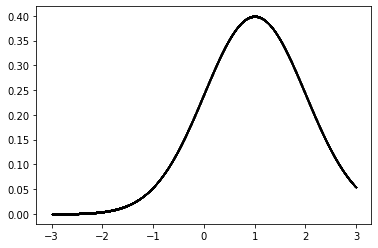

In [4]:
@vectorize([float32(float32)], target='parallel', fastmath=True)
def gaus(x):
    return 1/np.sqrt(2*np.pi) * np.exp(-1/2 * (x-1)**2)

x = np.asarray(np.random.rand(100000)*6 - 3).astype(np.float32)
plt.plot(x, gaus(x), 'o', ms=0.05, color='black')

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

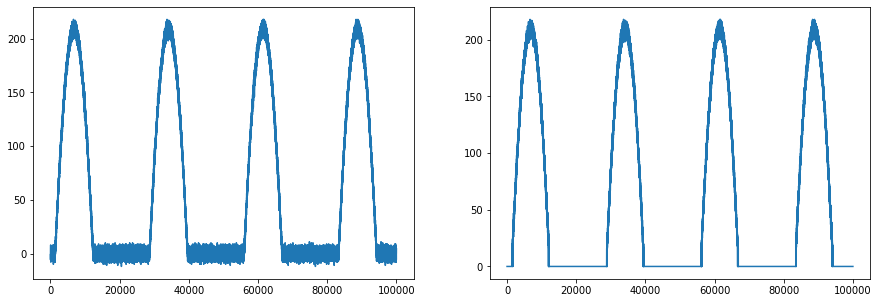

In [5]:
%matplotlib inline

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

from numba import jit, int16, void, cuda
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].plot(data)

@jit([void(int16[:])], nopython=True) #takes more time than the normal implementation
def zero_suppress1(data):
    data[data < 15] = 0

@jit([void(int16[:])], nopython=True)# numba likes cicles
def zero_suppress2(data):
    for i, val in enumerate(data):
        if val < 15:
            data[i] = 0
            
def zero_suppress3(data):
    data[data < 15] = 0

zero_suppress2(data)
ax[1].plot(data)

In [6]:
%timeit zero_suppress1(data)
%timeit zero_suppress2(data)
%timeit zero_suppress3(data)

10000 loops, best of 3: 143 µs per loop
10000 loops, best of 3: 37 µs per loop
The slowest run took 25.53 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 78.6 µs per loop


## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [7]:
X = np.random.rand(3,3)
Y = np.random.rand(3,3)

def k(x, y, a, c):
    return np.tanh(a*np.dot(x,y) + c)

k_numba = jit('f8[:,:](f8[:,:], f8[:,:], f4, f4)', fastmath=True, nopython=True)(k)

print(k_numba(X, Y, 1., 0.))
%timeit k(X, Y, 1., 0.)
%timeit k_numba(X, Y, 1., 0.)

<ipython-input-7-cb2cc3ad2917>:5: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  return np.tanh(a*np.dot(x,y) + c)


[[0.5137151  0.44920345 0.42002652]
 [0.73768976 0.76357289 0.60853999]
 [0.4165034  0.43430665 0.2649317 ]]
The slowest run took 13.11 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 3.28 µs per loop
The slowest run took 16.94 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 1.41 µs per loop


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [15]:
@cuda.jit
def triple_kernel(mat):
    x = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    y = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
    z = cuda.threadIdx.z + cuda.blockIdx.z * cuda.blockDim.z
    if x < mat.shape[0] and y < mat.shape[1] and z < mat.shape[2]:
        mat[x,y,z] = math.cos(mat[x,y,z])

In [16]:
M = np.random.rand(256,256,256)
threadsperblock = (32,32,32)
blockspergrid_x = int(M.shape[0] / threadsperblock[0])
blockspergrid_y = int(M.shape[1] / threadsperblock[1])
blockspergrid_z = int(M.shape[2] / threadsperblock[2])
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)
triple_kernel[threadsperblock, blockspergrid](M)
print(M)

[[[0.99999579 0.76877658 0.56450017 ... 0.8195615  0.99947674 0.81665167]
  [0.8697603  0.73303681 0.61423771 ... 0.58746773 0.86263747 0.93658341]
  [0.91537438 0.85927473 0.61892345 ... 0.97433861 0.81144161 0.70983989]
  ...
  [0.70175476 0.59679847 0.86128036 ... 0.62748047 0.76826209 0.94549078]
  [0.97550311 0.99719149 0.95313898 ... 0.81441001 0.66937185 0.6757778 ]
  [0.89596735 0.82871618 0.77077479 ... 0.88514082 0.9934137  0.92270661]]

 [[0.85168064 0.8274301  0.72735245 ... 0.98865532 0.77308663 0.81588987]
  [0.96142057 0.89283735 0.99299949 ... 0.62892488 0.96371136 0.93059994]
  [0.83260375 0.74171174 0.95984691 ... 0.81646085 0.88549016 0.56344919]
  ...
  [0.82199888 0.62985636 0.9158243  ... 0.95479866 0.74157078 0.80520597]
  [0.82746198 0.80761642 0.92422974 ... 0.85858403 0.88083167 0.81919642]
  [0.59942961 0.93899714 0.99891936 ... 0.97395658 0.73550857 0.90080092]]

 [[0.75704837 0.95909331 0.98631388 ... 0.99114886 0.6754295  0.91722916]
  [0.56203083 0.953130

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [11]:
from __future__ import division
from numba import cuda
import numpy as np
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.random.randint(0,100, size=(24,12))
B = np.random.randint(0, 100, size=(12,22))
C = np.zeros((24,12))

# Configure the blocks
threadsperblock = (12,2)
blockspergrid_x = int(24/threadsperblock[0])
blockspergrid_y = int(22/threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)
matmul[threadsperblock, blockspergrid](A,B,C)
print(C)


[[29143. 24850. 15650. 21039. 27728. 41089. 29694. 18269. 23655. 23902.
  24406. 19506.]
 [42344. 37757. 30924. 33500. 45181. 69952. 50027. 32029. 38328. 37633.
  42637. 39164.]
 [29534. 18942. 12173. 23081. 25123. 39395. 27147. 12888. 21499. 18574.
  19081. 25495.]
 [25813. 22942. 23953. 28050. 26567. 41718. 30447. 22124. 25535. 30323.
  29894. 23476.]
 [28856. 21849. 16829. 25454. 27813. 41696. 32909. 18730. 22733. 22526.
  22436. 24392.]
 [32068. 20914. 19632. 24562. 29583. 43080. 27836. 15289. 31664. 23997.
  23116. 26307.]
 [39556. 34269. 25071. 29697. 43155. 58204. 43767. 24819. 37754. 33178.
  37359. 28513.]
 [34215. 26601. 23283. 23947. 35465. 51618. 37044. 21635. 32180. 25340.
  28268. 30091.]
 [29493. 27153. 21301. 23898. 30515. 46039. 36631. 23677. 25884. 20432.
  24625. 21519.]
 [24347. 17882. 11059. 18613. 27173. 39895. 29322. 11903. 20826. 20771.
  22589. 25392.]
 [40064. 33001. 28482. 33229. 40651. 58930. 44300. 27129. 38072. 31803.
  34206. 31113.]
 [26267. 26208. 21935